In [1]:
import json
import numpy as np
import pandas as pd
import gzip

# Familiarize Yourself with the Dataset
In the lab sessions, we will work with the "All Beauty" category of the Amazon Review Data, and we will use the 5-core subset. You can download the dataset and find information about it here: https://nijianmo.github.io/amazon/index.html

## Exercise 1
Download and import the 5-core dataset.

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('All_Beauty_5.json.gz')

## Exercise 2
Clean the dataset from missing ratings and duplicates (cases where the same user has rated the same item multiple times) if any. How many observations does the cleaned dataset have?

In [11]:
nonan_df = df.dropna(axis=0,subset = ['overall'])
nonan_df = nonan_df.sort_values(['unixReviewTime'],ascending=False)
norepeat_df = nonan_df.drop_duplicates(['reviewerID','asin'],keep='first')
print(len(norepeat_df))

4092


## Exercise 3
Create a test set by extracting the latest (in time) positively rated item (rating $\geq 4$) by each user. Remove users that do not appear in the training set. How many observations does the training and test set have?

In [12]:

""" grouped_id = norepeat_df.groupby('reviewerID').apply(lambda t: t[t.unixReviewTime==t.unixReviewTime.max()])
grouped_id = [int(list(i)[1]) for i in grouped_id.index] """
test_set = norepeat_df[norepeat_df['overall']>=4]
grouped_id = test_set.groupby('reviewerID')['unixReviewTime'].idxmax()
test_set = test_set.loc[grouped_id]
train_set = pd.concat([norepeat_df, test_set, test_set]).drop_duplicates(['reviewerID','asin'],keep=False)
no_in_ID = [i for i in test_set.index if test_set['reviewerID'][i] not in list(train_set['reviewerID'])]
test_set = pd.concat([test_set, test_set.loc[no_in_ID], test_set.loc[no_in_ID]]).drop_duplicates(['reviewerID','asin'],keep=False)


## Exercise 4
### 4.1
Compute the number of ratings per user in the training set. What is the summary statistics of the number of ratings, and how does a histogram look like? <br>
Reflect on how a collaborative filtering and a content-based recommender system, respectively, will perform for users with few ratings.

In [13]:
import matplotlib.pyplot as plt

In [14]:
#vote = train_set['vote'].apply(lambda i : int(float((i.replace(',',''))) if i == i else 0))
train_id_of_account = train_set['reviewerID'].drop_duplicates(keep='first')
train_num_of_vote_per_account = [len(train_set.loc[train_set['reviewerID'] == id]) for id in train_id_of_account]
print('mean = %.6f\n'%np.mean(train_num_of_vote_per_account),
'std = %.6f\n'%np.std(train_num_of_vote_per_account),
'min_num = %.6f\n'%np.min(train_num_of_vote_per_account),
'max_num = %.6f\n'%np.max(train_num_of_vote_per_account),
'num_25 = %.6f\n'%np.percentile(train_num_of_vote_per_account, 25),
'num_50 = %.6f\n'%np.percentile(train_num_of_vote_per_account, 50),
'num_75 = %.6f\n'%np.percentile(train_num_of_vote_per_account, 75))

mean = 3.193680
 std = 0.610143
 min_num = 1.000000
 max_num = 9.000000
 num_25 = 3.000000
 num_50 = 3.000000
 num_75 = 3.000000



(array([0.00510204, 0.04285714, 0.7377551 , 0.19591837, 0.01020408,
        0.00816327]),
 array([1, 2, 3, 4, 5, 6, 7]),
 <BarContainer object of 6 artists>)

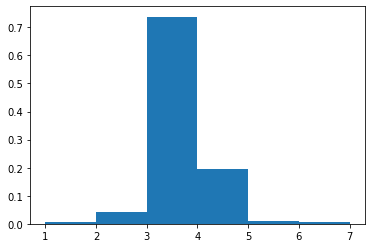

In [20]:
plt.hist(train_num_of_vote_per_account,bins=[1,2,3,4,5,6,7],density=True)

### 4.2
Compute the number of ratings per item in the training set. How does a barplot of the number of ratings ordered by decreasing frequency look like? <br>
Reflect on how it will affect the prediction process of a recommender system if only a small fraction of the items are rated frequently. <br>
<br>
Repeat this exercise on the test set and reflect on how the evaluation of a recommender system can be affected by popular items.

<BarContainer object of 77 artists>

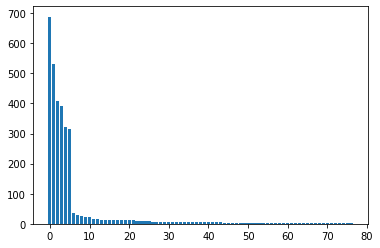

In [16]:
train_id_of_item = train_set['asin'].drop_duplicates(keep='first')
train_num_of_vote_per_item = [len(train_set.loc[train_set['asin'] == id]) for id in train_id_of_item]
train_num_of_vote_per_item.sort()
train_num_of_vote_per_item.reverse()
plt.bar(range(len(train_num_of_vote_per_item)), train_num_of_vote_per_item)

<BarContainer object of 43 artists>

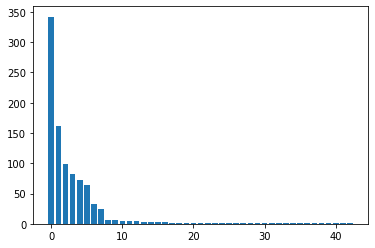

In [17]:
test_id_of_item = test_set['asin'].drop_duplicates(keep='first')
test_num_of_vote_per_item = [len(test_set.loc[test_set['asin'] == id]) for id in test_id_of_item]
test_num_of_vote_per_item.sort()
test_num_of_vote_per_item.reverse()
plt.bar(range(len(test_num_of_vote_per_item)), test_num_of_vote_per_item)

### 4.3
Compute the mean rating per user in the training set. What is the summary statistics of the rating means, and how does a histogram look like? <br>
Reflect on how a recommender system can take into account if different users rate on different "scales" (e.i. a rating of $3$ may be high for one user while low for another).<br>
<br>
Repeat this exercise with mean rating per item.

In [18]:
train_id_of_account = train_set['reviewerID'].drop_duplicates(keep='first')
train_rate_of_vote_per_account = [train_set.loc[train_set['reviewerID'] == id]['overall'].sum()/len(train_set.loc[train_set['reviewerID'] == id]) for id in train_id_of_account]
print('mean = %.6f\n'%np.mean(train_rate_of_vote_per_account),
'std = %.6f\n'%np.std(train_rate_of_vote_per_account),
'min_num = %.6f\n'%np.min(train_rate_of_vote_per_account),
'max_num = %.6f\n'%np.max(train_rate_of_vote_per_account),
'num_25 = %.6f\n'%np.percentile(train_rate_of_vote_per_account, 25),
'num_50 = %.6f\n'%np.percentile(train_rate_of_vote_per_account, 50),
'num_75 = %.6f\n'%np.percentile(train_rate_of_vote_per_account, 75))

mean = 4.765800
 std = 0.724105
 min_num = 1.000000
 max_num = 5.000000
 num_25 = 5.000000
 num_50 = 5.000000
 num_75 = 5.000000



(array([0.02140673, 0.01223242, 0.02752294, 0.08358818, 0.85524975]),
 array([1, 2, 3, 4, 5, 6]),
 <BarContainer object of 5 artists>)

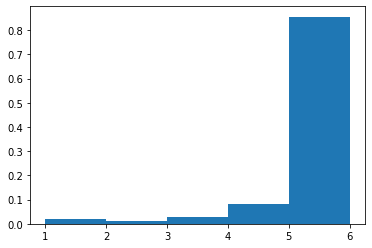

In [19]:
plt.hist(train_rate_of_vote_per_account,bins=[1,2,3,4,5,6],density=True)

In [168]:
train_id_of_item = train_set['asin'].drop_duplicates(keep='first')
train_rate_of_vote_per_item = [train_set.loc[train_set['asin'] == id]['overall'].sum()/len(train_set.loc[train_set['asin'] == id]) for id in train_id_of_item]
print('mean = %.6f\n'%np.mean(train_rate_of_vote_per_item),
'std = %.6f\n'%np.std(train_rate_of_vote_per_item),
'min_num = %.6f\n'%np.min(train_rate_of_vote_per_item),
'max_num = %.6f\n'%np.max(train_rate_of_vote_per_item),
'num_25 = %.6f\n'%np.percentile(train_rate_of_vote_per_item, 25),
'num_50 = %.6f\n'%np.percentile(train_rate_of_vote_per_item, 50),
'num_75 = %.6f\n'%np.percentile(train_rate_of_vote_per_item, 75))

mean = 4.239019
 std = 0.923015
 min_num = 1.000000
 max_num = 5.000000
 num_25 = 3.866776
 num_50 = 4.572727
 num_75 = 5.000000



(array([0.02631579, 0.05263158, 0.18421053, 0.44736842, 0.28947368]),
 array([1, 2, 3, 4, 5, 6]),
 <BarContainer object of 5 artists>)

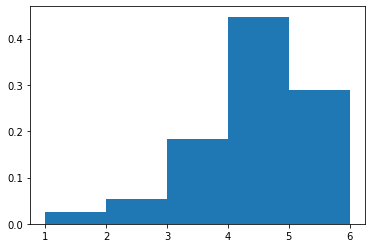

In [169]:
plt.hist(train_rate_of_vote_per_item ,bins=[1,2,3,4,5,6],density=True)